# Training an Image Classification model for NACTI

Train a model on the inclusive empty vs animal dataframes

### Set up the environment

In [4]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, TensorBoard

from collections import Counter

import pandas as pd

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [5]:
# path to the model weights files.
# weights_path = '../keras/examples/vgg16_weights.h5'
# top_model_weights_path = 'fc_model.h5'
# dimensions of our images.
img_width, img_height = 224, 224

train_dataframe_path = '/data/dataframes/inclusiveEVATrain.csv'
validation_data_dir = '/data/dataframes/inclusiveEVATest.csv'
checkpoint_dir = '/data/ResNet50/ResNet50_20190404_inclusiveEVA_weights.h5'
tensorboard_dir = '/data/ResNet50/inclusiveEva/logs'
nb_train_samples = 50000
nb_validation_samples = 10000
epochs = 25
batch_size = 64
# gpu_count = 2

### Import the dataframes

In [6]:
# Import the training and validation dataframes
train_df = pd.read_csv(train_dataframe_path)
val_df = pd.read_csv(validation_data_dir)

# Check to ensure that the camera trap locations are disjoint
assert len(train_df[train_df['cam_location'].isin(val_df['cam_location'].unique())]) == 0, "Train and validation are not disjoint"

# Get the number of classes
min(train_df['target'].nunique(), val_df['target'].nunique())

2

### Build the model

In [7]:
# build the MobileNetV2 network
ResNet50 = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(196, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Make it a multi-gpu model if available
# model = multi_gpu_model(model, gpus=gpu_count)

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=checkpoint_dir, verbose=1, save_best_only=True)
tboard = TensorBoard(tensorboard_dir)

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Create Data Generators

In [10]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='abs_file_path', 
    y_col ='target', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=True,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_dataframe(
    val_df, 
    x_col='abs_file_path', 
    y_col ='target', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=True,
    class_mode='categorical')

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  
print(class_weights)

Found 145639 images belonging to 2 classes.
Found 51361 images belonging to 2 classes.
{0: 1.0, 1: 1.0426800190748688}


Define the weights

In [11]:
if max([v for k,v in class_weights.items()]) < 2:
    class_weights = {0:1, 1:1}

### Train the model

In [12]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples//batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size, 
    class_weight=class_weights, 
    max_queue_size=batch_size*4,
    callbacks=[checkpointer, tboard])

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
781/781 [==============================] - 1491s 2s/step - loss: 0.3226 - acc: 0.8743 - val_loss: 0.5562 - val_acc: 0.7521

Epoch 00001: val_loss improved from inf to 0.55618, saving model to /data/ResNet50/ResNet50_20190404_inclusiveEVA_weights.h5
Epoch 2/25
781/781 [==============================] - 1469s 2s/step - loss: 0.2096 - acc: 0.9195 - val_loss: 0.7481 - val_acc: 0.7092

Epoch 00002: val_loss did not improve from 0.55618
Epoch 3/25
781/781 [==============================] - 1466s 2s/step - loss: 0.1849 - acc: 0.9287 - val_loss: 0.6217 - val_acc: 0.7505

Epoch 00003: val_loss did not improve from 0.55618
Epoch 4/25
781/781 [==============================] - 1427s 2s/step - loss: 0.1688 - acc: 0.9354 - val_loss: 0.5545 - val_acc: 0.7711

Epoch 00004: val_loss improved from 0.55618 to 0.55448, saving model to /data/ResNet50/ResNet50_20190404_inclusiveEVA_weights.h5
Epoch 5/25
781/781 [==============================] - 14

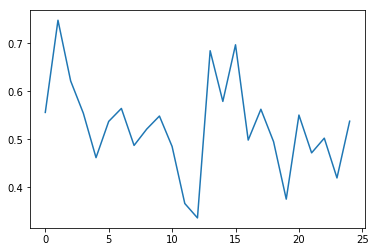

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['val_loss'])

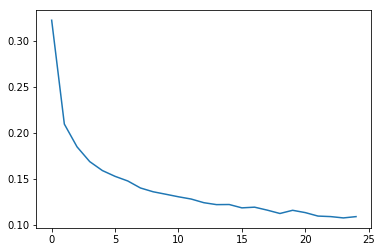

In [20]:
plt.plot(history.history['loss'])

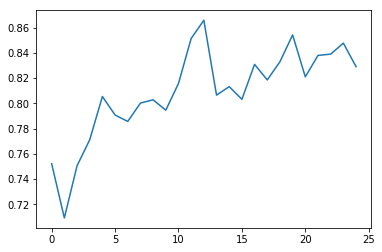

In [23]:
plt.plot(history.history['val_acc'])

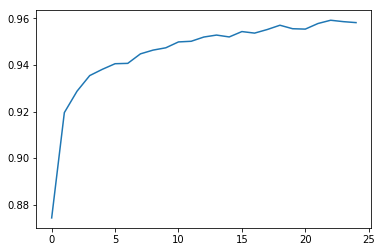

In [24]:
plt.plot(history.history['acc'])